The data used in this notebook was sourced from this Kaggle Dataset: https://www.kaggle.com/datasets/rohit265/credit-card-eligibility-data-determining-factors 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cat

In [4]:
df = pd.read_csv('./dataset.csv')

First, let's begin with some basic examination of our data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [6]:
df.nunique()

ID                 9709
Gender                2
Own_car               2
Own_property          2
Work_phone            2
Phone                 2
Email                 2
Unemployed            2
Num_children          9
Num_family           10
Account_length       61
Total_income        263
Age                7172
Years_employed     3637
Income_type           5
Education_type        5
Family_status         5
Housing_type          6
Occupation_type      19
Target                2
dtype: int64

In [25]:
df.describe()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Target
count,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.348749,0.367700,0.671542,0.217427,0.287671,0.087548,0.174683,0.422804,2.182614,27.270059,1.812282e+05,43.784093,5.664730,0.132145
std,4.080270e+04,0.476599,0.482204,0.469677,0.412517,0.452700,0.282650,0.379716,0.767019,0.932918,16.648057,9.927731e+04,11.625768,6.342241,0.338666
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.700000e+04,20.504186,0.000000,0.000000
25%,5.036955e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.000000,1.125000e+05,34.059563,0.928150,0.000000
50%,5.069449e+06,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,26.000000,1.575000e+05,42.741466,3.761884,0.000000
75%,5.112986e+06,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,41.000000,2.250000e+05,53.567151,8.200031,0.000000
max,5.150479e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.000000,20.000000,60.000000,1.575000e+06,68.863837,43.020733,1.000000


Very interesting data here, some notable points, not all of which may be directly useful to our end analysis:
- Our target variable is pretty unbalanced, with only 13.2% of this sample being eligible for a credit card
- 67.2% of the sample owns a property (words given in the dataset definition, which I assume referes to real estate) but only 28.6% have an phone and only 36.8% own a car. This is not in line with my expectations and raises flags about potentially applying conclusions from this dataset. Where did this come from? When did this data come from? How was this data collected?
- Another oddity, the median age is 42.7 years but the median years of employment is less than 4. Even with stay-at-home spouses or similar explanations, this seems very odd. Will need to investigate further.
- If you subtract the given quantiles of Account_length from the given quantiles of Age, some of these people had to have had their accounts since their early to mid teenage years. Age of account opening could be an interesting feature to engineer.
- The 25th percentile of income is $112,500? But only 13.2% of people were eligible for a credit card? What currency is this? Was assuming dollars a bad choice?

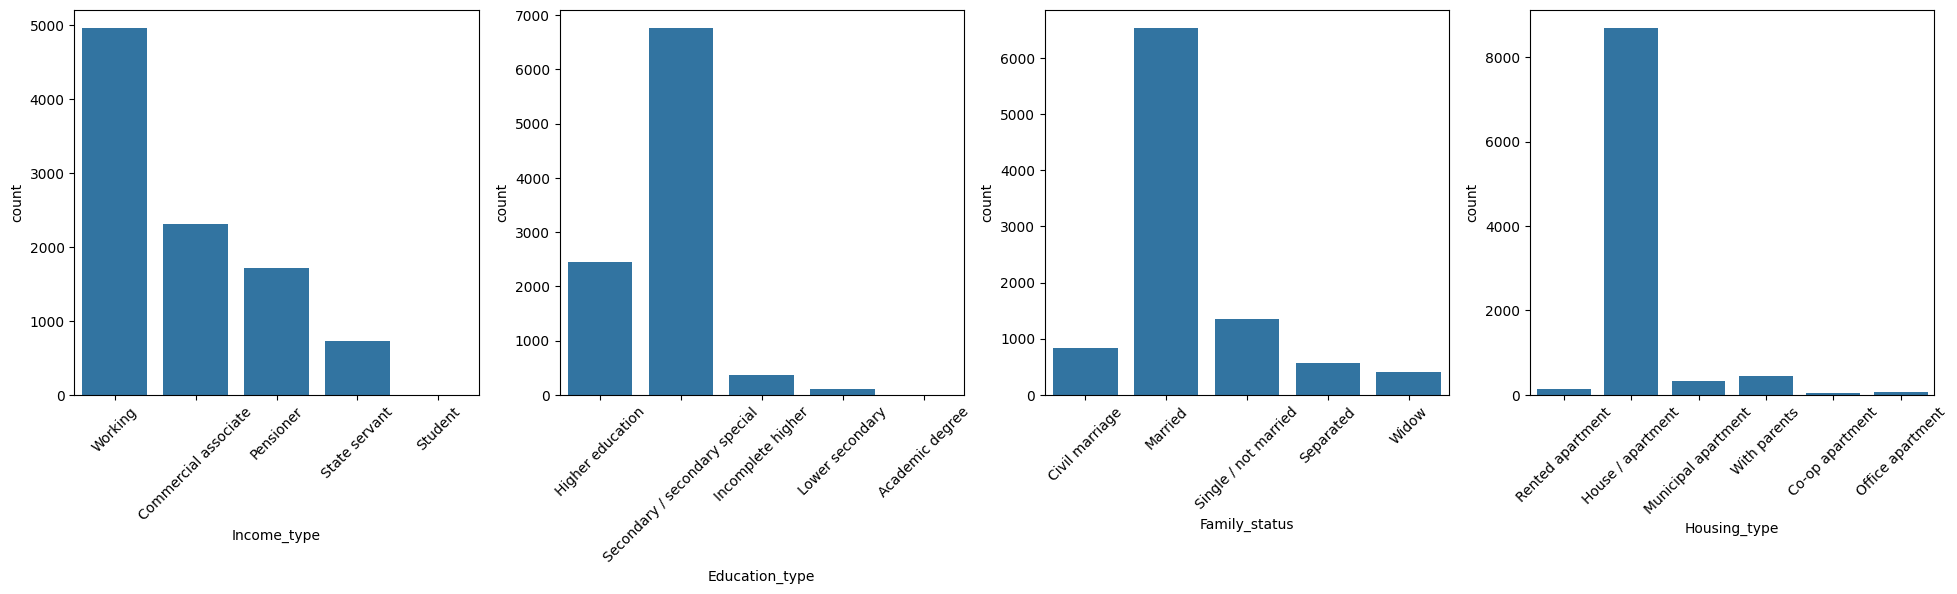

In [16]:

fig, ax = plt.subplots(1, 4, figsize=(24, 5))

sns.countplot(x='Income_type', data=df, ax=ax[0])
sns.countplot(x='Education_type', data=df, ax=ax[1])
sns.countplot(x='Family_status', data=df, ax=ax[2])
sns.countplot(x='Housing_type', data=df, ax=ax[3])

for i in range(4):
    ax[i].tick_params(axis='x', rotation=45)

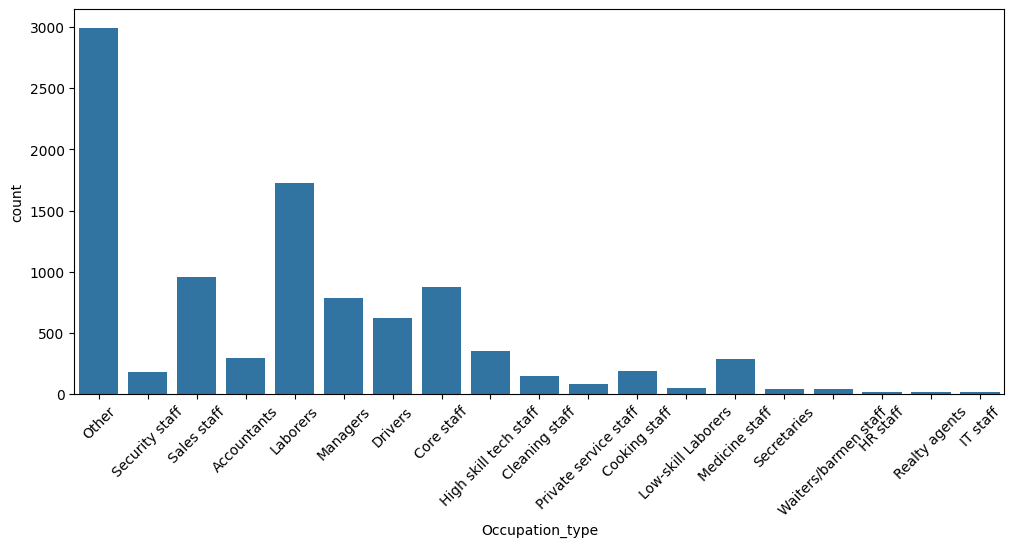

In [23]:
fig= plt.figure(figsize=(12, 5))

sns.countplot(x='Occupation_type', data=df)
# Rotate x-labels and do not show output except chart
_ = plt.xticks(rotation=45)

There isn't too much interesting from just the distributions of these categorical variables. The first four distributions do show distributions with a disproportionate amount of one type, with housing type in particular being incredibly heavily slanted. The Occupation_type distribution isn't particularly interesting at first glance, other than it isn't a distribution I might expect to have a median income of $112,500. This lends further credence to this not being US dollars.